Choosing and Explaining Likely Caravan Insurance Customers

Programming Language: R 3.5.1 in Jupyter Notebook

R Libraries used:
- caret
- psych
- MASS
- gridExtra
- leap


## Table of Contents

* [Introduction](#sec_1)
* [Data Exploration](#sec_2)
* [Model Development](#sec_3)
* [Model Comparison](#sec_4)
* [Variable Identification and Explanation](#sec_5)
* [Conclusion](#sec_6)
* [References](#sec_7)

## 1. Introduction <a class="anchor" id="sec_1"></a>

This notebook aims at analysing a car insurance data set, which is based on real world business data. The analysis is based on two tasks that needs to be completed as part of the evaluation :

• prediction : This tasks aims at predicting the potential customers that may be willing to buy the caravan insurance policy. The prediction is based on the data provided about the customer such as their demographic details or policies they are already holding.

• description : This task aims at explaining the results predict by the model. It tries to back the prediction and tries to find out the relation between the model and the prediction.

To begin with, we start by lading a few libraries that are required to complete the task. 

In [1]:
library(caret)
library(psych)
library(gridExtra) 
library(MASS)
library(lattice)
library(leaps)

Warning message:
“package ‘caret’ was built under R version 3.5.2”Loading required package: lattice
Loading required package: ggplot2
Warning message:
“package ‘ggplot2’ was built under R version 3.5.2”
Attaching package: ‘psych’

The following objects are masked from ‘package:ggplot2’:

    %+%, alpha

Warning message:
“package ‘MASS’ was built under R version 3.5.2”

## 2. Data Exploration <a class="anchor" id="sec_2"></a>

Before we build any model for prediction, one of the most important task is to understand the data in hand. We need to know the distribution of data and how the features change with respect to each other. This section uses various measures to find explore the data and get insight of the data that may be useful before building the model.

We start by loading the data that is a text file and cleaning the data a little bit so that it is easy for us to understand troughout. Each attribute is named and the nominal variables are factorised as the numbers do not have any relation among themselves. 

Here, on thing that is important to note is that we only factorize the nominal variables and not the ordinal variables as we can use the order that they have to our advantage.

The reason data exploration is very imporatant and in a lot of cases more important that modelling the data is because the data genrally contains a lot number of features, in this case 85 and not all features are useful to predict the result. If all the features are kept, the model may be overfitted to the training data and can not preduce quality predictions when new data is fed to it. Therefore, data exploration can be used so as to reduce number of features.

The features that can be removed can be summarized as those :
* features who have low variance as they won't be able to explain the changes in target variables well
* feautes that have low correlation with the target
* features that have high correlation with other features

In [2]:
column_names = c("cust subtype","no houses","size household","age","cust type","roman catholic","protestant","other religion","no religion","married","living together","other relation","singles","household without children","household with children","high education","medium education","lower education","high status","entrepreneur","farmer","middle management","skilled labourers","unskilled labourers","class A","class B1","class B2","class C","class D","rented house","home owners","1 car","2 cars","no car","national health service","private health insurance","Income < 30","Income 30-45","Income 45-75","Income 75-122","Income >123","income","purchasing power","contribution private third party","contribution third party(firms)","contribution third party(agriculture)","contribution car","contribution delivery van","contribution motorcycle/scooter","contribution lorry","contribution trailer","contribution tractor","contribution agricultural machines","contribution moped","contribution life insurances","contribution private accident","contribution family accidents","contribution disability","contribution fire","contribution surfboard","contribution boat","contribution bicycle","contribution property","contribution social security","private third party insurance","third party(firms)","third party(agriculture)","car policies","delivery van policies","motorcycle/scooter policies","lorry policies","trailer policies","tractor policies","agricultural machines policies","moped policies","life insurances","private accident policies","family accidents policies","disability policies","fire policies","surfboard policies","boat policies","bicycle policies","property policies","security policies","caravan")

In [3]:
insurance_data <- read.table("ticdata2000.txt",col.names=column_names)
insurance_val <- read.table("ticeval2000.txt",col.names=column_names[-86])
insurance_target <- read.table("tictgts2000.txt")

insurance_data$cust.subtype = as.factor(insurance_data$cust.subtype)
insurance_data$cust.type = as.factor(insurance_data$cust.type)
insurance_val$cust.subtype = as.factor(insurance_val$cust.subtype)
insurance_val$cust.type = as.factor(insurance_val$cust.type)
insurance_data$caravan = as.factor(insurance_data$caravan)

To guess the distribution of the features and know the basic statistics of the data it is generally preferred look at the `summary` of the data 

In [4]:
summary(insurance_data)

  cust.subtype    no.houses      size.household       age          cust.type   
 33     : 810   Min.   : 1.000   Min.   :1.000   Min.   :1.000   8      :1563  
 8      : 339   1st Qu.: 1.000   1st Qu.:2.000   1st Qu.:2.000   3      : 886  
 38     : 339   Median : 1.000   Median :3.000   Median :3.000   9      : 667  
 39     : 328   Mean   : 1.111   Mean   :2.679   Mean   :2.991   5      : 569  
 9      : 278   3rd Qu.: 1.000   3rd Qu.:3.000   3rd Qu.:3.000   1      : 552  
 23     : 251   Max.   :10.000   Max.   :5.000   Max.   :6.000   7      : 550  
 (Other):3477                                                    (Other):1035  
 roman.catholic     protestant    other.religion  no.religion   
 Min.   :0.0000   Min.   :0.000   Min.   :0.00   Min.   :0.000  
 1st Qu.:0.0000   1st Qu.:4.000   1st Qu.:0.00   1st Qu.:2.000  
 Median :0.0000   Median :5.000   Median :1.00   Median :3.000  
 Mean   :0.6965   Mean   :4.627   Mean   :1.07   Mean   :3.259  
 3rd Qu.:1.0000   3rd Qu.:6.000   3

The summary gives us a few imporant insights of the data in hand.

* Firstly, it tells us that the caravan feature is very imbalanced with only 348 positives and 5474 negatives.
* Secondly, it shows that almost all the data is in the same range. That is 0 to 10 for the most cases.
* Finally, it helps us understand the distribution of each feature and helps us understand the spread of each feature. This helps us understand that features similar to `number of houses` are not spread evenly and have same value for majority of the data and hence would be comparitively less important for the model for prediction.  


Another way to check the statistics along with characteristics of the distribution, we can use `describe()` and get even better insight of the data.

In [5]:
describe(insurance_data)

,vars,n,mean,sd,median,trimmed,mad,min,max,range,skew,kurtosis,se
cust.subtype*,1,5822,23.5865682,12.4154441,29,24.2756548,11.8608,1,40,39,-0.41872404,-1.34496743,0.162714463
no.houses,2,5822,1.1106149,0.4058421,1,1.0000000,0.0000,1,10,9,7.41560941,99.98537492,0.005318889
size.household,3,5822,2.6788045,0.7898345,3,2.6449120,1.4826,1,5,4,0.18337935,0.01093010,0.010351422
age,4,5822,2.9912401,0.8145888,3,2.9506226,0.0000,1,6,5,0.47173241,0.61903466,0.010675847
cust.type*,5,5822,5.7736173,2.8567598,7,5.9012452,2.9652,1,10,9,-0.33135845,-1.34546433,0.037440154
roman.catholic,6,5822,0.6964960,1.0032338,0,0.5206097,0.0000,0,9,9,2.23693514,8.61679968,0.013148192
protestant,7,5822,4.6269323,1.7158425,5,4.6326750,1.4826,0,9,9,0.07449209,0.45420859,0.022487508
other.religion,8,5822,1.0699072,1.0175025,1,0.9574925,1.4826,0,5,5,0.90184897,0.78812149,0.013335196
no.religion,9,5822,3.2585022,1.5976466,3,3.3209532,1.4826,0,9,9,-0.13124562,-0.03204130,0.020938454
married,10,5822,6.1834421,1.9094825,6,6.3278231,1.4826,0,9,9,-0.71875777,0.68126357,0.025025316


Here, the summary gives us a really important insight of the data that can be used for feature reduction. The standard deviation for a lot of features is very low, i.e. close to zero. This implies these features are mostly constant throughout the data and hence could not contibute in deriving a relationship between the features and the target variable. Therefore, these feature can be removed from the data.

#### Removing Highly Correlated Attributes

We start of by removing highly correlated attributes. One of the features that catches my attention even before checking for the correlation among the features is `customer type` and `customer subtype`. We can start by finding if they are related in any way or not and if they are then which one of the nominal variables can describe the target better.

We start by creating a frequency table of each type to capture the relationship

In [6]:
freq_table = table(insurance_data$cust.subtype, insurance_data$cust.type) 
freq_table  


    
       1   2   3   4   5   6   7   8   9  10
  1  124   0   0   0   0   0   0   0   0   0
  2   82   0   0   0   0   0   0   0   0   0
  3  249   0   0   0   0   0   0   0   0   0
  4   52   0   0   0   0   0   0   0   0   0
  5   45   0   0   0   0   0   0   0   0   0
  6    0 119   0   0   0   0   0   0   0   0
  7    0  44   0   0   0   0   0   0   0   0
  8    0 339   0   0   0   0   0   0   0   0
  9    0   0 278   0   0   0   0   0   0   0
  10   0   0 165   0   0   0   0   0   0   0
  11   0   0 153   0   0   0   0   0   0   0
  12   0   0 111   0   0   0   0   0   0   0
  13   0   0 179   0   0   0   0   0   0   0
  15   0   0   0   5   0   0   0   0   0   0
  16   0   0   0  16   0   0   0   0   0   0
  17   0   0   0   9   0   0   0   0   0   0
  18   0   0   0  19   0   0   0   0   0   0
  19   0   0   0   3   0   0   0   0   0   0
  20   0   0   0   0  25   0   0   0   0   0
  21   0   0   0   0  15   0   0   0   0   0
  22   0   0   0   0  98   0   0   0   0   0
  23 

Here it is very important to understand the the data in the table is not randomly distributed. This indicates relation between customer subtype and customer type. Now checking at the `summary()` we know that the distribution among the customer subtype is more spread than the distibution among customer type. Hence, I chose to remove customer type and keep customer subtype.

In [7]:
insurance_data = insurance_data[,-5]
insurance_val = insurance_val[,-5]

Now, we start of by taking numeric and ordinal data to find the correlation among themselves. Here, categorical variables are removed because correlation is better with numerical variables and makes little sence with respect to categorical varibales.

In [8]:
numeric_data = insurance_data[c(-1,-85)]
corr_mat = cor(numeric_data)

Here, we print the highly correlated attributes and their correlation. For this task I have used a correlation threshold of 90% either positive or negative to find highly correlated attributes.

In [9]:
del_attribute = c()
for (i in c(1:83)){
    for (j in c(1:i)){
        if ((corr_mat[i,j] >= 0.90) || ((corr_mat[i,j] <= -0.90))){
            coln = colnames(corr_mat)[j]
            rown = colnames(corr_mat)[i]
            if (rown != coln){
                val = corr_mat[i,j]
                del_attribute <- c(del_attribute, coln)
                print(paste(coln," & ",rown,"    :    ",val))   
            }
        }
    }  
}

[1] "rented.house  &  home.owners     :     -0.999553947445255"
[1] "national.health.service  &  private.health.insurance     :     -0.999239298766863"
[1] "contribution.private.third.party  &  private.third.party.insurance     :     0.981369175933941"
[1] "contribution.third.party.agriculture.  &  third.party.agriculture.     :     0.987578617328343"
[1] "contribution.car  &  car.policies     :     0.916154488158895"
[1] "contribution.delivery.van  &  delivery.van.policies     :     0.902995584471846"
[1] "contribution.motorcycle.scooter  &  motorcycle.scooter.policies     :     0.904855171005691"
[1] "contribution.lorry  &  lorry.policies     :     0.948663332964804"
[1] "contribution.trailer  &  trailer.policies     :     0.966080507278704"
[1] "contribution.tractor  &  tractor.policies     :     0.929817837170216"
[1] "contribution.agricultural.machines  &  agricultural.machines.policies     :     0.909670650335681"
[1] "contribution.moped  &  moped.policies     :     0.96970758396

Here we can see highly correlated features. Looking at the output it is quite easy to understand and think why these attributes have such high correlation. For instance `rented.house` and `home.owner` have correlation almost equal to 1. It is almost certain than people owning a house would not rent a house to stay in which is why they have such a high negative correlation value. Also, looking at other features it is obvious that if a person buys any policy the contibution of the policy increase with some amount and hence contibution and number of policies are highly correlated. 

Now it is good to remove such attributes because keeping both the variables though would predict similar results but would produce high pariance in the model thereby compromising the explainability of the model which is an important aspect of model creation in the first place.

In [10]:
# attributes to be deleted due to high correlation
del_attribute

[1] "rented.house"                         
 [2] "national.health.service"              
 [3] "contribution.private.third.party"     
 [4] "contribution.third.party.agriculture."
 [5] "contribution.car"                     
 [6] "contribution.delivery.van"            
 [7] "contribution.motorcycle.scooter"      
 [8] "contribution.lorry"                   
 [9] "contribution.trailer"                 
[10] "contribution.tractor"                 
[11] "contribution.agricultural.machines"   
[12] "contribution.moped"                   
[13] "contribution.family.accidents"        
[14] "contribution.disability"              
[15] "contribution.boat"                    
[16] "contribution.bicycle"                 
[17] "contribution.social.security"

In [11]:
insurance_data = insurance_data[ , !(names(insurance_data) %in% del_attribute)]
numeric_data = numeric_data[ , !(names(numeric_data) %in% del_attribute)]
insurance_val = insurance_val[ , !(names(insurance_val) %in% del_attribute)]

In [12]:
dim(insurance_data)

[1] 5822   68

Here, we can see that the number of attributes are reduced from 85 to 67 (excluding the target variable) which is much better to work on.

#### Removing variables with low variance 

After we have removed highly correlated features, now we can remove features with low variance as they won't be spread across to explain the changes in target variable. Here, the threshold for low variance is kept as 0.05 i.e. if the variance is below the threshold value then the feature is considered not useful for prediction. 

One important thing while removing such features is that, since the data is imbalanced, we need to take keep the features that may have low variance in entire data but have somewhat more variance in the data for the customers that bought the caravan policy

In [13]:
caravan_0 = subset(insurance_data,caravan %in% c(0))
caravan_1 = subset(insurance_data,caravan %in% c(1))

In [14]:
var_total = apply(insurance_data, 2, var)
low_var_total = c()
for (i in c(1:length(var_total))){
    
    if (var_total[i] < 0.05){
        low_var_total <- c(low_var_total, names(var_total)[i])
    }
}

In [15]:
var_1 = apply(caravan_1, 2, var)
low_var_1 = c()
for (i in c(1:length(var_1))){
    
    if (var_1[i] < 0.05){
        low_var_1 <- c(low_var_1, names(var_1)[i])
    }
}

Finding attribute names with low variance in total as well as in group buying the caravan policy and then removing those attributes.

In [16]:
del_attributes = low_var_total[low_var_total %in% low_var_1]
del_attributes

[1] "contribution.private.accident"  "contribution.surfboard"        
 [3] "contribution.property"          "third.party.firms."            
 [5] "third.party.agriculture."       "delivery.van.policies"         
 [7] "lorry.policies"                 "trailer.policies"              
 [9] "agricultural.machines.policies" "private.accident.policies"     
[11] "family.accidents.policies"      "disability.policies"           
[13] "surfboard.policies"             "boat.policies"                 
[15] "property.policies"              "security.policies"

In [17]:
insurance_data = insurance_data[ , !(names(insurance_data) %in% del_attributes)]
numeric_data = numeric_data[ , !(names(numeric_data) %in% del_attributes)]
insurance_val = insurance_val[ , !(names(insurance_val) %in% del_attributes)]

In [18]:
dim(insurance_data)

[1] 5822   52

Here, we can see that the number of attributes is reduced to 51 (excluding the target variable) from 68.

## Removing attributes having low correlation with target

Another set of features that can be removed before making the model are those whose change in values do not explain the change in taget variables i.e. very less related to target variable. 

Since the target variable is a factor and not numerical we can perform the chi-squared test to check for independence.

In [19]:
del_attribute = c()
for (each in c(1:length(names(insurance_data)))){
    tbl = table(insurance_data[,each], insurance_data[,52]) 
    z = chisq.test(tbl)
    if( z$p.value > 0.05){
        del_attribute <- c(del_attribute, names(insurance_data[each]))   
    }
}
del_attribute


Warning message in chisq.test(tbl):
“Chi-squared approximation may be incorrect”Warning message in chisq.test(tbl):
“Chi-squared approximation may be incorrect”Warning message in chisq.test(tbl):
“Chi-squared approximation may be incorrect”Warning message in chisq.test(tbl):
“Chi-squared approximation may be incorrect”Warning message in chisq.test(tbl):
“Chi-squared approximation may be incorrect”Warning message in chisq.test(tbl):
“Chi-squared approximation may be incorrect”Warning message in chisq.test(tbl):
“Chi-squared approximation may be incorrect”Warning message in chisq.test(tbl):
“Chi-squared approximation may be incorrect”Warning message in chisq.test(tbl):
“Chi-squared approximation may be incorrect”Warning message in chisq.test(tbl):
“Chi-squared approximation may be incorrect”Warning message in chisq.test(tbl):
“Chi-squared approximation may be incorrect”Warning message in chisq.test(tbl):
“Chi-squared approximation may be incorrect”Warning message in chisq.test(tbl):
“Chi

[1] "no.houses"                       "size.household"                 
 [3] "age"                             "roman.catholic"                 
 [5] "living.together"                 "household.without.children"     
 [7] "household.with.children"         "entrepreneur"                   
 [9] "class.B2"                        "X2.cars"                        
[11] "Income.30.45"                    "Income..123"                    
[13] "contribution.third.party.firms." "contribution.life.insurances"   
[15] "motorcycle.scooter.policies"     "tractor.policies"

In [20]:
insurance_data = insurance_data[ , !(names(insurance_data) %in% del_attribute)]
numeric_data = numeric_data[ , !(names(numeric_data) %in% del_attribute)]
insurance_val = insurance_val[ , !(names(insurance_val) %in% del_attribute)]

In [21]:
dim(insurance_data)

[1] 5822   36

Here, we can see that the number of dimensions are reduced to 35 (excluding the target variable). This is much less than the number of features we started with.

Now, we can use another method called backward feature selection to remove not so important features. This method can be used even in the begining but by reducing the obviously not so important features, we reduced the computation complexity by a huge amount.

In [22]:
insurance_data$cust.subtype =as.numeric(levels(insurance_data$cust.subtype))[insurance_data$cust.subtype]
insurance_data$cust.subtype =as.integer(insurance_data$cust.subtype)
features.fit = regsubsets(caravan~.,data=insurance_data,method = "backward",nvmax=34)
features.fit.summary = summary(features.fit)
features.fit.summary

Subset selection object
Call: regsubsets.formula(caravan ~ ., data = insurance_data, method = "backward", 
    nvmax = 34)
35 Variables  (and intercept)
                              Forced in Forced out
cust.subtype                      FALSE      FALSE
protestant                        FALSE      FALSE
other.religion                    FALSE      FALSE
no.religion                       FALSE      FALSE
married                           FALSE      FALSE
other.relation                    FALSE      FALSE
singles                           FALSE      FALSE
high.education                    FALSE      FALSE
medium.education                  FALSE      FALSE
lower.education                   FALSE      FALSE
high.status                       FALSE      FALSE
farmer                            FALSE      FALSE
middle.management                 FALSE      FALSE
skilled.labourers                 FALSE      FALSE
unskilled.labourers               FALSE      FALSE
class.A                        

It is very important to understand that increasing number of features to an extent can improve the result of the model but by increasing the number of features, the computational cost increases. Therefore, we are interested in knowing that sweet spot where we can reduce the computational cost without compromising the outcome by much.

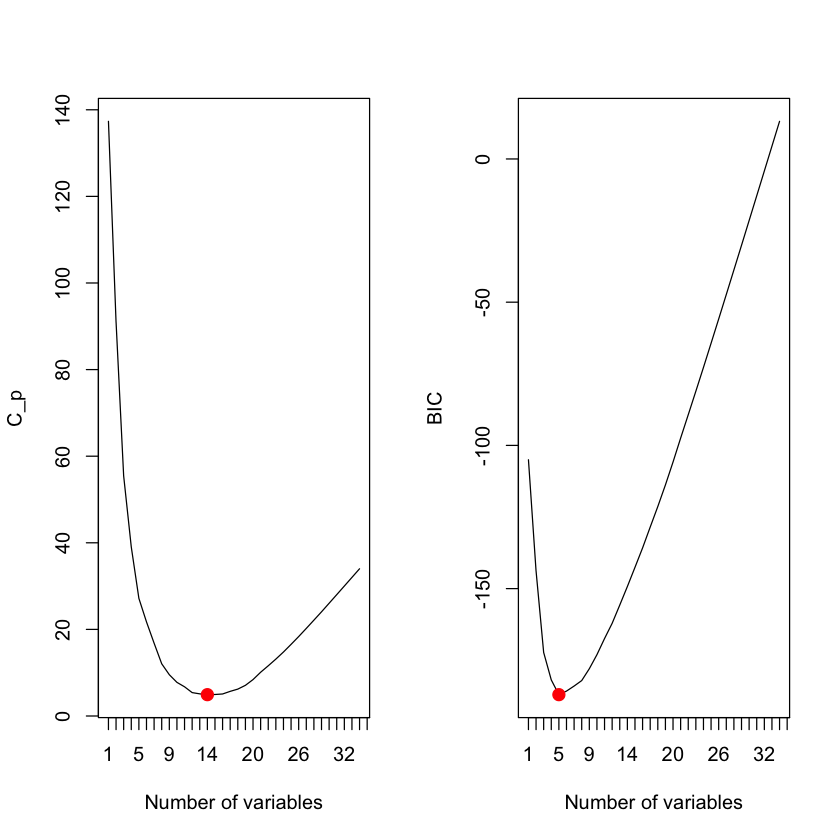

In [23]:
v1 =seq(1,36,1)
par(mfrow = c(1, 2))
plot(features.fit.summary$cp, xlab = "Number of variables", ylab = "C_p", type = "l",xaxt="n")
points(which.min(features.fit.summary$cp), features.fit.summary$cp[which.min(features.fit.summary$cp)], col = "red", cex = 2, pch = 20)
axis(side = 1, at = v1)
plot(features.fit.summary$bic, xlab = "Number of variables", ylab = "BIC", type = "l",xaxt="n")
axis(side = 1, at = v1)
points(which.min(features.fit.summary$bic), features.fit.summary$bic[which.min(features.fit.summary$bic)], col = "red", cex = 2, pch = 20)


Here we can see that the number of features that can be used is 14 if we measuring the performance using Mallow's CP while the BIC suggest 5.

By using number of features suggested by both the models it was noticed that the accuracy of the model did not increase by much when we used 14 features intead of 5. So therefore, it is better to use 5 features rather than 14 if the results produced by them are almost similar.

Extracting most relevant features suggested by stepwise selection technique.

In [24]:
a =coef(features.fit, 5)

In [25]:
keep_attr = names(a)[-1]

In [26]:
final_data = insurance_data[ , (names(insurance_data) %in% keep_attr)]
final_data["caravan"] = insurance_data$caravan
final_data["cust.subtype"] = insurance_data$cust.subtype
insurance_data = final_data

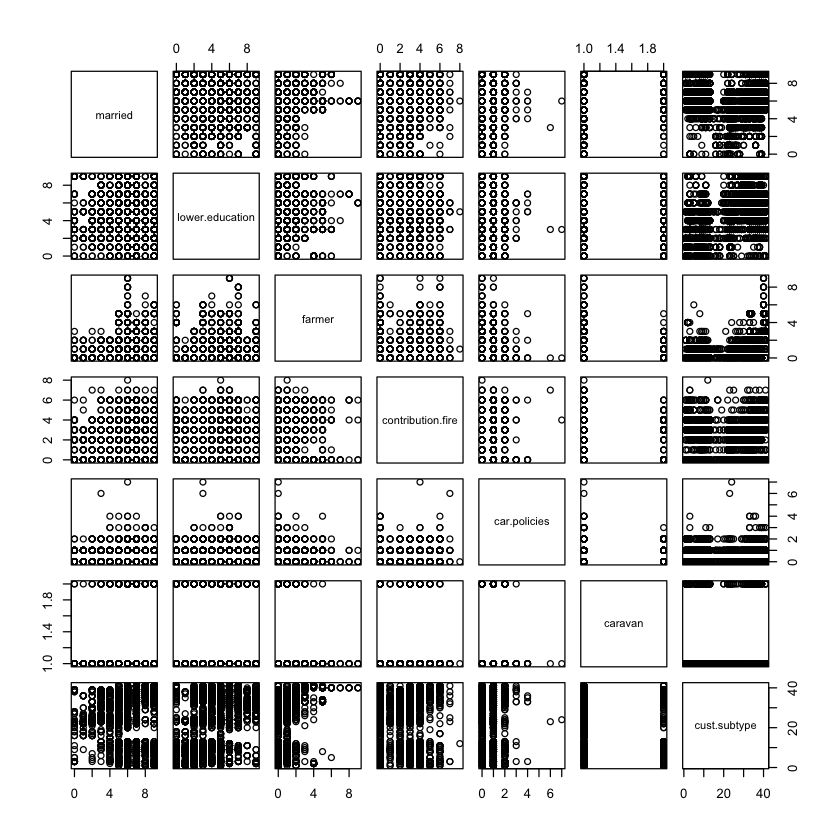

In [27]:
pairs(insurance_data)

From the pair plot above we see that now the final attributes have no relation with caravan policies.

In [28]:
keep_attr

[1] "married"           "lower.education"   "farmer"           
[4] "contribution.fire" "car.policies"

After exploring the data the number of features are reduced to 5 from 85 which is remarkably good as it reduces the computational cost by a huge amount.

## Model Development  <a class="anchor" id="sec_3"></a>

After we have a set of relevant features, next task is to build a model using those features to predict the outcome. Here there are two models that are created i.e. `glm` and `LDA` to use for the prediction task. 

Also, since the data is imbalanced, `resampling` is also used to make the data much balanced. As generally, in the given problem statement, we would be interested in knowing `true positives` rather than true negatives, resampling method can derive better results. Though it decreses the `accuracy` by a small amount, it can increase the `sensitivity` which is more important for the task.

In [29]:
caravan_0 = subset(insurance_data,caravan %in% c(0))
caravan_1 = subset(insurance_data,caravan %in% c(1))
caravan_count_0 = dim(caravan_0)[1]
caravan_count_1 = dim(caravan_1)[1]
train_sample_size_1 =  round(dim(caravan_1)[1])
train_sample_size_0 =  train_sample_size_1
number_of_iterations = round(caravan_count_0/caravan_count_1) 

The module below is a test glm model that runs only once, i.e. for the first sample. The module returns the summary of the glm model. This is to check the approximate of parameters that are returned when a prediction is made.

In [30]:
model_glm_test <- function(train,test){
    fit.glm = glm(caravan ~ ., data = train,family=binomial)
    summary(fit.glm)
}

The module below is a glm model that runs with 16 different samples and predicts the probability of customers to buy the caravan policy for the validation set.

In [31]:
model_glm <- function(train,test){
    fit.glm = glm(caravan ~ .  , data = train,family=binomial)
    pred.glm = predict(fit.glm, test,type = "response")
    pred.glm
    
    
}

The module below is a LDA model that runs with 16 different samples and predicts the probability of customers to buy the caravan policy for the validation set.

In [32]:
model_lda <- function(train,test){
    fit.lda = lda(caravan ~. , data = train)
    pred.lda = predict(fit.lda, test)
    pred.lda$posterior[,2]
}



The module below tries to make the sample population close to actual population by adding customers from each subtype.

In [33]:
get_train_df <- function(data_frame){
    
    for (each_subtype in (1:42)){
        subtype_frame = subset(insurance_data,cust.subtype %in% c(each_subtype))
        row = subtype_frame[sample(nrow(subtype_frame),1,replace = FALSE),]
        data_frame = rbind(data_frame, row)         
    }
    data_frame  
    
}

This module below makes use of resmpling by making 16 random samples to train the model. The number of iterations i.e. 16 was carefully chosen which is equal to the number of people not buying the caravan policy which is the majority divided by the number of people buying the policy. By doing so we try to cover as many people from the population in either of the samples as the samples are chosen randomly. This way we lose comparitively less amount of information in total and also make the samples balanced. 

After feeding the model with different sample, we give same evaluation set to all the models. Each model predicts the probability of each customer to buy the caravan policy differently and return it. The returned probabilities are later averaged to get the final prediction.

In [34]:
for (i in c(1:number_of_iterations)){

    train_0 = caravan_0[sample(nrow(caravan_0),train_sample_size_0 ,replace = FALSE), ]
    train_0 = get_train_df(train_0)
    train_1 = caravan_1
    train = rbind(train_0, train_1) 
    train = train[-length(train)]
    if (i == 1){
        
        prediction_test_summary = model_glm_test(train,insurance_val)
        predictions_lda = model_lda(train,insurance_val)
        predictions_glm = model_glm(train,insurance_val)
  
    }else{
        predictions_lda = cbind(predictions_lda,model_lda(train,insurance_val))
        predictions_glm = cbind(predictions_glm,model_glm(train,insurance_val))
        
        
    }
    
}



### Model Comparison and Evaluation   <a class="anchor" id="sec_4"></a>

In [35]:
prediction_test_summary


Call:
glm(formula = caravan ~ ., family = binomial, data = train)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-2.1151  -1.0061  -0.5353   1.0346   2.0977  

Coefficients:
                  Estimate Std. Error z value Pr(>|z|)    
(Intercept)       -1.43122    0.36285  -3.944 8.00e-05 ***
married            0.16758    0.04531   3.698 0.000217 ***
lower.education   -0.12381    0.03509  -3.528 0.000419 ***
farmer            -0.31928    0.09335  -3.420 0.000626 ***
contribution.fire  0.10011    0.04399   2.276 0.022873 *  
car.policies       0.94074    0.14079   6.682 2.36e-11 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 1018.55  on 735  degrees of freedom
Residual deviance:  901.38  on 730  degrees of freedom
AIC: 913.38

Number of Fisher Scoring iterations: 4


Here, we can see that all the variables that we used are significant in terms of the result produced which can be observed from the p values. Also, the deviance residual that is produced is small and is approximately normally distributed which can be figured out from the summary. 

In [36]:
cust_subset_glm = c(1:4000)
cust_subset_lda = c(1:4000)
for (i in c(1:4000)){
    cust_subset_glm[i] = (sum(predictions_glm[i,]))/16
    cust_subset_lda[i] = (sum(predictions_lda[i,]))/16
}

final_prediction = (cust_subset_glm + cust_subset_lda)/2
customer_number = c(1:4000)
prediction_df = data.frame(customer_number,final_prediction)


### Model 1 (glm)

In [37]:
confusionMatrix(table(round(cust_subset_glm), insurance_target[,1]),positive="1")

Confusion Matrix and Statistics

   
       0    1
  0 2721  103
  1 1041  135
                                         
               Accuracy : 0.714          
                 95% CI : (0.6997, 0.728)
    No Information Rate : 0.9405         
    P-Value [Acc > NIR] : 1              
                                         
                  Kappa : 0.1021         
                                         
 Mcnemar's Test P-Value : <2e-16         
                                         
            Sensitivity : 0.56723        
            Specificity : 0.72329        
         Pos Pred Value : 0.11480        
         Neg Pred Value : 0.96353        
             Prevalence : 0.05950        
         Detection Rate : 0.03375        
   Detection Prevalence : 0.29400        
      Balanced Accuracy : 0.64526        
                                         
       'Positive' Class : 1              
                                         

### Model 2 (LDA)

In [38]:
confusionMatrix(table(round(cust_subset_lda), insurance_target[,1]),positive="1")

Confusion Matrix and Statistics

   
       0    1
  0 2725  102
  1 1037  136
                                         
               Accuracy : 0.7153         
                 95% CI : (0.701, 0.7292)
    No Information Rate : 0.9405         
    P-Value [Acc > NIR] : 1              
                                         
                  Kappa : 0.1041         
                                         
 Mcnemar's Test P-Value : <2e-16         
                                         
            Sensitivity : 0.5714         
            Specificity : 0.7243         
         Pos Pred Value : 0.1159         
         Neg Pred Value : 0.9639         
             Prevalence : 0.0595         
         Detection Rate : 0.0340         
   Detection Prevalence : 0.2933         
      Balanced Accuracy : 0.6479         
                                         
       'Positive' Class : 1              
                                         

### Model 3 (LDA + GLM)

In [39]:
confusionMatrix(table(round(prediction_df[,2]), insurance_target[,1]),positive="1")

Confusion Matrix and Statistics

   
       0    1
  0 2722  103
  1 1040  135
                                       
               Accuracy : 0.7143       
                 95% CI : (0.7, 0.7282)
    No Information Rate : 0.9405       
    P-Value [Acc > NIR] : 1            
                                       
                  Kappa : 0.1022       
                                       
 Mcnemar's Test P-Value : <2e-16       
                                       
            Sensitivity : 0.56723      
            Specificity : 0.72355      
         Pos Pred Value : 0.11489      
         Neg Pred Value : 0.96354      
             Prevalence : 0.05950      
         Detection Rate : 0.03375      
   Detection Prevalence : 0.29375      
      Balanced Accuracy : 0.64539      
                                       
       'Positive' Class : 1            
                                       

Here we can see that all the models produce almost same results in terms of accuracy, sensitivity, specificity and prevalence. For this particular problem statement, though the accuracy is low, still in my opinion accuracy is not a good meausure to evaluate the model.The sensitivity of the model is an important parameter in evaluating the model as in the problem statement we should be more focused on finding the customers who can actually by the caravan rather than on those who can not buy the caravan policy. 

### Prediction

Since all the models produce almost same results, I would like to choose model three for prediction as in my opinion it merges both the models and gives a slightly more reliable result.

Here, we sort first 800 customers that are potential buyers and then calculate the accuracy of the model.

In [40]:
customer_interested = prediction_df[order(-final_prediction),]
customer_interested = customer_interested[1:800,]
customer_interested = round(customer_interested)

To measure the accuracy of your model the task suggests to identify the 800 customers who are most likely to have a caravan policy, and then compute the fraction of customers identified that actually bought a caravan insurance
policy using `“TICTGTS2000.txt”`.

In [41]:
cnt = 0
cust_no = customer_interested$customer_number
for (i in c(1:800)){
    if(customer_interested[i,2]==1 &&  insurance_target[cust_no[i],]==1){
        cnt = cnt+1
        
    }
    
}
cnt

[1] 112

In [42]:
accuracy = cnt / 238 # 238 is the number of positives in the target dataset
accuracy

[1] 0.4705882

## Variable Identification and Explanation  <a class="anchor" id="sec_5"></a>

In [43]:
prediction_test_summary


Call:
glm(formula = caravan ~ ., family = binomial, data = train)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-2.1151  -1.0061  -0.5353   1.0346   2.0977  

Coefficients:
                  Estimate Std. Error z value Pr(>|z|)    
(Intercept)       -1.43122    0.36285  -3.944 8.00e-05 ***
married            0.16758    0.04531   3.698 0.000217 ***
lower.education   -0.12381    0.03509  -3.528 0.000419 ***
farmer            -0.31928    0.09335  -3.420 0.000626 ***
contribution.fire  0.10011    0.04399   2.276 0.022873 *  
car.policies       0.94074    0.14079   6.682 2.36e-11 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 1018.55  on 735  degrees of freedom
Residual deviance:  901.38  on 730  degrees of freedom
AIC: 913.38

Number of Fisher Scoring iterations: 4


Also, it is quite interesting to see the sign of the estimates given by the model. Here lower education and farmers are given a negative signs as it is quite obvious that people belonging to both the groups are not economically stable enough to buy the caravan. To add on, the farmers have a more negative estimate than the lower education certainly because they have even lesser chances of buying a carvan and hence even the caravan policies.

Secondly, it is interesting to see marital status plays a pocitive role in the buying of the policy. It could be because of a number of reasons, such as the people who are married have better purchsing power which can be verified fom the correlation matrix. 

Also, it looks quite surprising to see fire policies to play a role in caravan policies as these two domains are completely different, but I feel that since fire policies are strongly related to Private third part insurance, it could play a role in this unexpected relation where private companies may manipulate customers to buy the policies.

Finally, it was not unusual that `car policies` is in the list. This is because people having the car have a higher chance of having a caravan than anyone else.


In [44]:
corr_mat

,no.houses,size.household,age,roman.catholic,protestant,other.religion,no.religion,married,living.together,other.relation,⋯,life.insurances,private.accident.policies,family.accidents.policies,disability.policies,fire.policies,surfboard.policies,boat.policies,bicycle.policies,property.policies,security.policies
no.houses,1.000000000,0.010102243,0.05697460,-0.006136360,-0.02436018,0.012056027,0.020540166,0.023024578,-0.03856563,-0.012544222,⋯,0.020926378,0.0033205607,0.0094435174,-0.0163329939,0.0006545495,-0.0061891407,0.0006662173,-0.020993273,0.0183037932,-0.004166222
size.household,0.010102243,1.000000000,-0.32825725,0.013105189,0.04935646,-0.108649617,-0.005527394,0.534797785,-0.17558615,-0.500734749,⋯,0.017427718,-0.0001283250,0.0167597277,0.0187492290,-0.0092689689,0.0092343649,0.0006443739,0.030330056,0.0259066857,0.028383762
age,0.056974604,-0.328257249,1.00000000,-0.037518737,0.09365402,0.057737161,-0.119966338,-0.040383808,-0.30740081,0.199773821,⋯,-0.025187048,0.0210701969,-0.0017470283,0.0006444196,0.0244168979,0.0002441930,-0.0017913964,0.020611609,-0.0200420361,-0.014539744
roman.catholic,-0.006136360,0.013105189,-0.03751874,1.000000000,-0.37276739,0.021125102,-0.063904415,-0.028594440,0.11757578,-0.003456761,⋯,0.003792742,-0.0084496474,0.0053862951,-0.0128432499,0.0019283957,-0.0006751743,0.0117945560,-0.001502914,-0.0114309114,-0.004008778
protestant,-0.024360178,0.049356463,0.09365402,-0.372767392,1.00000000,-0.317548571,-0.741894511,0.147256295,-0.21103140,-0.084050503,⋯,-0.018459129,-0.0143545843,0.0039492314,0.0039747163,0.0463522124,0.0137600087,0.0184678037,0.001906471,0.0023918343,0.016657867
other.religion,0.012056027,-0.108649617,0.05773716,0.021125102,-0.31754857,1.000000000,-0.139306355,-0.125703467,0.11176214,0.105340040,⋯,0.003050293,0.0065716077,-0.0055693135,0.0176955827,0.0063015379,-0.0238772539,0.0094173615,0.025661055,-0.0097344391,0.010127307
no.religion,0.020540166,-0.005527394,-0.11996634,-0.063904415,-0.74189451,-0.139306355,1.000000000,-0.107899577,0.15955308,0.071837834,⋯,0.010169288,0.0088443705,0.0042418594,-0.0041392047,-0.0526046474,-0.0084119000,-0.0264073491,-0.011121966,0.0072612796,-0.027291255
married,0.023024578,0.534797785,-0.04038381,-0.028594440,0.14725629,-0.125703467,-0.107899577,1.000000000,-0.47834065,-0.884361888,⋯,0.015055761,0.0115124386,0.0223758364,0.0116780108,-0.0079785097,0.0097105773,-0.0015655294,0.020921355,-0.0034195098,0.036568846
living.together,-0.038565630,-0.175586147,-0.30740081,0.117575776,-0.21103140,0.111762144,0.159553081,-0.478340648,1.00000000,0.084755392,⋯,0.003739560,-0.0205018773,-0.0078946000,-0.0111572250,-0.0004703521,-0.0207711079,0.0197738557,-0.037474485,0.0183959072,-0.013834785
other.relation,-0.012544222,-0.500734749,0.19977382,-0.003456761,-0.08405050,0.105340040,0.071837834,-0.884361888,0.08475539,1.000000000,⋯,-0.015726203,-0.0068564122,-0.0235741698,-0.0036618178,0.0129517027,-0.0038286829,-0.0063107543,-0.007909229,-0.0026024131,-0.039980805


###  Conclusion  <a class="anchor" id="sec_6"></a>

The two tasks gave a better understanding of the data exploration and feature selection. We started with 86 feature and came down to as less as 5 towards the end. It helped us understand the distribution of data and how it effects the model. Not only this but also it gave us a better understanding of the model development and especially resampling method used in the case of highly imbalaced data. It gave us a working experience of using resampling method to increase the sensitivity of the model. Finally, it gave us an understanding of the measures used to evaluate the model. It made clear that accuracy can not always be used to evaluate the model but it depends on the purpose of the model to choose from the measures that can be used to evaluate it's performance. 